In [1]:
from google.colab import files
uploaded = files.upload()


Saving splits_amr_gene_family.zip to splits_amr_gene_family (1).zip


In [2]:
!unzip -q splits_amr_gene_family.zip


In [4]:
# ============================================================
# Bayesian MetaOptNet (MEGARes) → CARD transfer
#   - works with amr_gene_family / mechanism / drug_class
#   - uses existing seq_manifest.csv + splits_*/K{1,3,5}
# ============================================================
import os, json, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path

# ---------- CONFIG ----------
MANIFEST    = "seq_manifest.csv"
STOI_JSON   = "stoi.json"
NUM_MEAN    = "num_mean.npy"
NUM_STD     = "num_std.npy"
CHECKPOINT  = "best_bayes_metaoptnet_cnn.pt"   # <- from Bayes training

# choose label + splits to use
LABEL_COL   = "amr_gene_family"                # or "mechanism" or "drug_single" etc.
SPLITS_ROOT = f"splits_{LABEL_COL}"           # must match how you created splits

K_VALUES    = [1, 3, 5]
N, Q        = 5, 15
KMER_K      = 5
MAX_LEN     = 512

# ---------- load manifest + assets ----------
manifest = pd.read_csv(MANIFEST, dtype=str)
manifest = manifest[["seq_id","sequence",LABEL_COL,"gc_content","seq_len"]].copy()
manifest["gc_content"] = manifest["gc_content"].astype(float)
manifest["seq_len"]    = manifest["seq_len"].astype(float)
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

with open(STOI_JSON) as f:
    stoi = json.load(f)
PAD, UNK = "<PAD>", "<UNK>"
pad_id = stoi.get(PAD, 0)
unk_id = stoi.get(UNK, 1)

num_mean = np.load(NUM_MEAN)
num_std  = np.load(NUM_STD)

# ---------- tokenizer / padding (match MEGARes) ----------
def kmers(seq, k=KMER_K):
    s = seq.upper()
    L = len(s)
    return [s[i:i+k] for i in range(L-k+1)] if L >= k else []

def encode_seq(seq):
    toks = kmers(seq, KMER_K)
    if not toks:
        return [unk_id]
    return [stoi.get(t, unk_id) for t in toks]

def pad_ids(ids, max_len=MAX_LEN, pad_id=pad_id):
    out = np.full((max_len,), pad_id, dtype=np.int64)
    s = ids[:max_len]
    out[:len(s)] = s
    return out

# ---------- encoder (same as Bayes training) ----------
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len,
                 embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7),
                 use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.pad_idx = pad_idx

        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])

        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        fused_in = conv_channels * len(kernel_sizes) * 2 + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

        # to match checkpoint keys
        self.log_temp = nn.Parameter(torch.zeros(1))

    def forward(self, tokens, nums):
        x = self.emb(tokens)
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)

        pooled = []
        for block in self.convs:
            h = block(x)
            pooled += [
                F.adaptive_max_pool1d(h, 1).squeeze(-1),
                F.adaptive_avg_pool1d(h, 1).squeeze(-1),
            ]

        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        h      = torch.cat([h_text, h_num], dim=1)

        z = self.proj(h)
        if self.use_cosine:
            z = F.normalize(z, p=2, dim=1)
        return z

# ---------- Bayesian MetaOptNet head (same as training) ----------
class BayesianRidgeHead(nn.Module):
    """
    W ~ N(0, tau^2 I),  y | W ~ N(ZW, sigma^2 I)
    """
    def __init__(self, init_log_tau2=-2.0, init_log_sigma2=0.0):
        super().__init__()
        self.log_tau2   = nn.Parameter(torch.tensor(init_log_tau2))
        self.log_sigma2 = nn.Parameter(torch.tensor(init_log_sigma2))

    def forward(self, s_z, s_y, q_z):
        device = s_z.device
        S, d = s_z.shape
        C = int(s_y.max().item()) + 1

        Y = F.one_hot(s_y, num_classes=C).float()
        Z = s_z

        tau2   = self.log_tau2.exp()
        sigma2 = self.log_sigma2.exp()

        A = (Z.t() @ Z) / sigma2 + torch.eye(d, device=device) / tau2   # [d,d]
        A_inv = torch.linalg.inv(A)                                     # [d,d]

        B = (Z.t() @ Y) / sigma2                                        # [d,C]
        W_mean = A_inv @ B                                              # [d,C]

        logits_mean = q_z @ W_mean                                      # [Q,C]

        qA = q_z @ A_inv                                                # [Q,d]
        var_per_query = sigma2 + (qA * q_z).sum(dim=1)                  # [Q]

        return logits_mean, var_per_query

# ---------- episode loader ----------
def load_episode(ep_dir: Path, label_col=LABEL_COL, device="cpu"):
    S = pd.read_csv(ep_dir/"support.csv")
    Q = pd.read_csv(ep_dir/"query.csv")

    labs = sorted(S[label_col].unique())
    lab2id = {l:i for i,l in enumerate(labs)}

    def make_batch(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            rec = seq_by_id[r["seq_id"]]
            ids = encode_seq(rec["sequence"])
            toks.append(pad_ids(ids))
            nums.append([rec["gc_content"], rec["seq_len"]])
            ys.append(lab2id[r[label_col]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys

    s_tok, s_num, s_y = make_batch(S)
    q_tok, q_num, q_y = make_batch(Q)
    return s_tok, s_num, s_y, q_tok, q_num, q_y, labs

# ---------- load Bayes checkpoint ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = CNNSeqEncoder(vocab_size=len(stoi), pad_idx=pad_id, max_len=MAX_LEN).to(device)
bayes_head = BayesianRidgeHead().to(device)

ckpt = torch.load(CHECKPOINT, map_location=device)
encoder.load_state_dict(ckpt["encoder"])
bayes_head.load_state_dict(ckpt["head"])
encoder.eval(); bayes_head.eval()

print("Loaded Bayesian checkpoint.")
print("  tau^2  =", bayes_head.log_tau2.exp().item())
print("  sigma^2=", bayes_head.log_sigma2.exp().item())

# ---------- evaluate per K ----------
for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])
    if not ep_dirs:
        print(f"[WARN] No episodes found for K={K} in {ep_root}")
        continue
    ep_dirs = ep_dirs[:600]

    accs, vars_all = [], []
    for ep in ep_dirs:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep, label_col=LABEL_COL, device=device)
        with torch.no_grad():
            s_z = encoder(s_tok, s_num)
            q_z = encoder(q_tok, q_num)
            logits_q, q_var = bayes_head(s_z, s_y, q_z)
            preds = logits_q.argmax(dim=1)
            accs.append((preds == q_y).float().mean().item())
            vars_all.append(q_var.mean().item())  # average predictive var in this episode

    accs = np.array(accs, float)
    vars_all = np.array(vars_all, float)
    print(
        f"[CARD Bayes @ {LABEL_COL}] K={K}: "
        f"acc={accs.mean():.3f} ± {accs.std():.3f}  "
        f"| mean var={vars_all.mean():.3e}"
        f" (n={len(accs)})"
    )


Loaded Bayesian checkpoint.
  tau^2  = 0.135811910033226
  sigma^2= 0.9964929223060608
[CARD Bayes @ amr_gene_family] K=1: acc=0.878 ± 0.113  | mean var=1.112e+00 (n=600)
[CARD Bayes @ amr_gene_family] K=3: acc=0.907 ± 0.094  | mean var=1.088e+00 (n=600)
[CARD Bayes @ amr_gene_family] K=5: acc=0.914 ± 0.094  | mean var=1.074e+00 (n=600)


In [5]:
#Shuffled-label sanity test (should drop to ≈ 0.2 acc), to ensure no leakage or bugs
from copy import deepcopy

print("\n=== Shuffled-label sanity check (should be ~0.20 acc) ===")
for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:200]  # 200 episodes is enough

    accs_shuf = []
    for ep in ep_dirs:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep, label_col=LABEL_COL, device=device)
        with torch.no_grad():
            s_z = encoder(s_tok, s_num)
            q_z = encoder(q_tok, q_num)
            logits_q, q_var = bayes_head(s_z, s_y, q_z)
            preds = logits_q.argmax(dim=1)

        # randomly permute the *true* labels -> should destroy structure
        perm = torch.randperm(len(q_y), device=q_y.device)
        q_y_shuf = q_y[perm]

        accs_shuf.append((preds == q_y_shuf).float().mean().item())

    accs_shuf = np.array(accs_shuf, float)
    print(f"[Shuffled @ {LABEL_COL}] K={K}: acc={accs_shuf.mean():.3f} ± {accs_shuf.std():.3f} (n={len(accs_shuf)})")
    print(f"  (Random baseline should be ≈ {1.0/float(N):.2f})")



=== Shuffled-label sanity check (should be ~0.20 acc) ===
[Shuffled @ amr_gene_family] K=1: acc=0.201 ± 0.044 (n=200)
  (Random baseline should be ≈ 0.20)
[Shuffled @ amr_gene_family] K=3: acc=0.197 ± 0.044 (n=200)
  (Random baseline should be ≈ 0.20)
[Shuffled @ amr_gene_family] K=5: acc=0.191 ± 0.047 (n=200)
  (Random baseline should be ≈ 0.20)


In [6]:
#Check correlation: accuracy vs predictive variance

all_points = []  # list of (K, episode_acc, episode_mean_var)

for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:600]

    for ep in ep_dirs:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep, label_col=LABEL_COL, device=device)
        with torch.no_grad():
            s_z = encoder(s_tok, s_num)
            q_z = encoder(q_tok, q_num)
            logits_q, q_var = bayes_head(s_z, s_y, q_z)
            preds = logits_q.argmax(dim=1)

        acc_ep = (preds == q_y).float().mean().item()
        mean_var_ep = q_var.mean().item()
        all_points.append((K, acc_ep, mean_var_ep))

all_points = np.array(all_points, float)
Ks_arr     = all_points[:,0]
acc_arr    = all_points[:,1]
var_arr    = all_points[:,2]

import numpy as np
corr = np.corrcoef(acc_arr, var_arr)[0,1]
print(f"\nCorrelation (episode acc vs mean variance): {corr:.3f} (expect negative)")



Correlation (episode acc vs mean variance): -0.230 (expect negative)


In [7]:
#quick per-K summary:
for K in K_VALUES:
    m = (Ks_arr == K)
    corrK = np.corrcoef(acc_arr[m], var_arr[m])[0,1]
    print(f"K={K}: corr(acc, var) = {corrK:.3f}")


K=1: corr(acc, var) = -0.340
K=3: corr(acc, var) = -0.349
K=5: corr(acc, var) = -0.446


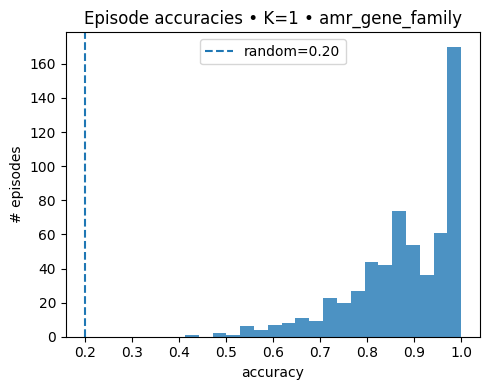

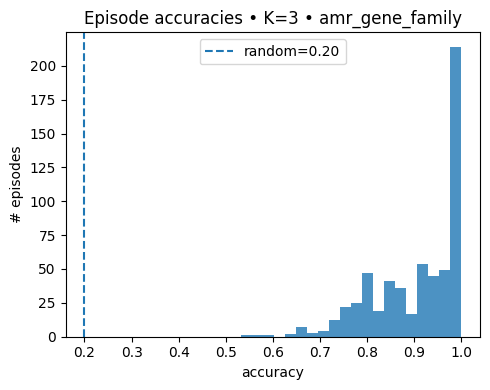

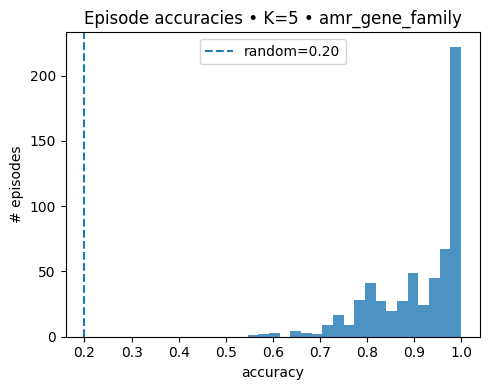

In [8]:
#histogram of episode accuracies
import matplotlib.pyplot as plt

for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:600]

    accs = []
    for ep in ep_dirs:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep, label_col=LABEL_COL, device=device)
        with torch.no_grad():
            s_z = encoder(s_tok, s_num)
            q_z = encoder(q_tok, q_num)
            logits_q, q_var = bayes_head(s_z, s_y, q_z)
            preds = logits_q.argmax(dim=1)
        accs.append((preds == q_y).float().mean().item())

    plt.figure(figsize=(5,4))
    plt.hist(accs, bins=20, alpha=0.8)
    plt.axvline(1.0/float(N), linestyle="--", label=f"random={1.0/float(N):.2f}")
    plt.title(f"Episode accuracies • K={K} • {LABEL_COL}")
    plt.xlabel("accuracy"); plt.ylabel("# episodes")
    plt.legend()
    plt.tight_layout()
    plt.show()


Running t-SNE on 800 CARD samples (amr_gene_family)...


/tmp/ipython-input-1845161307.py:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


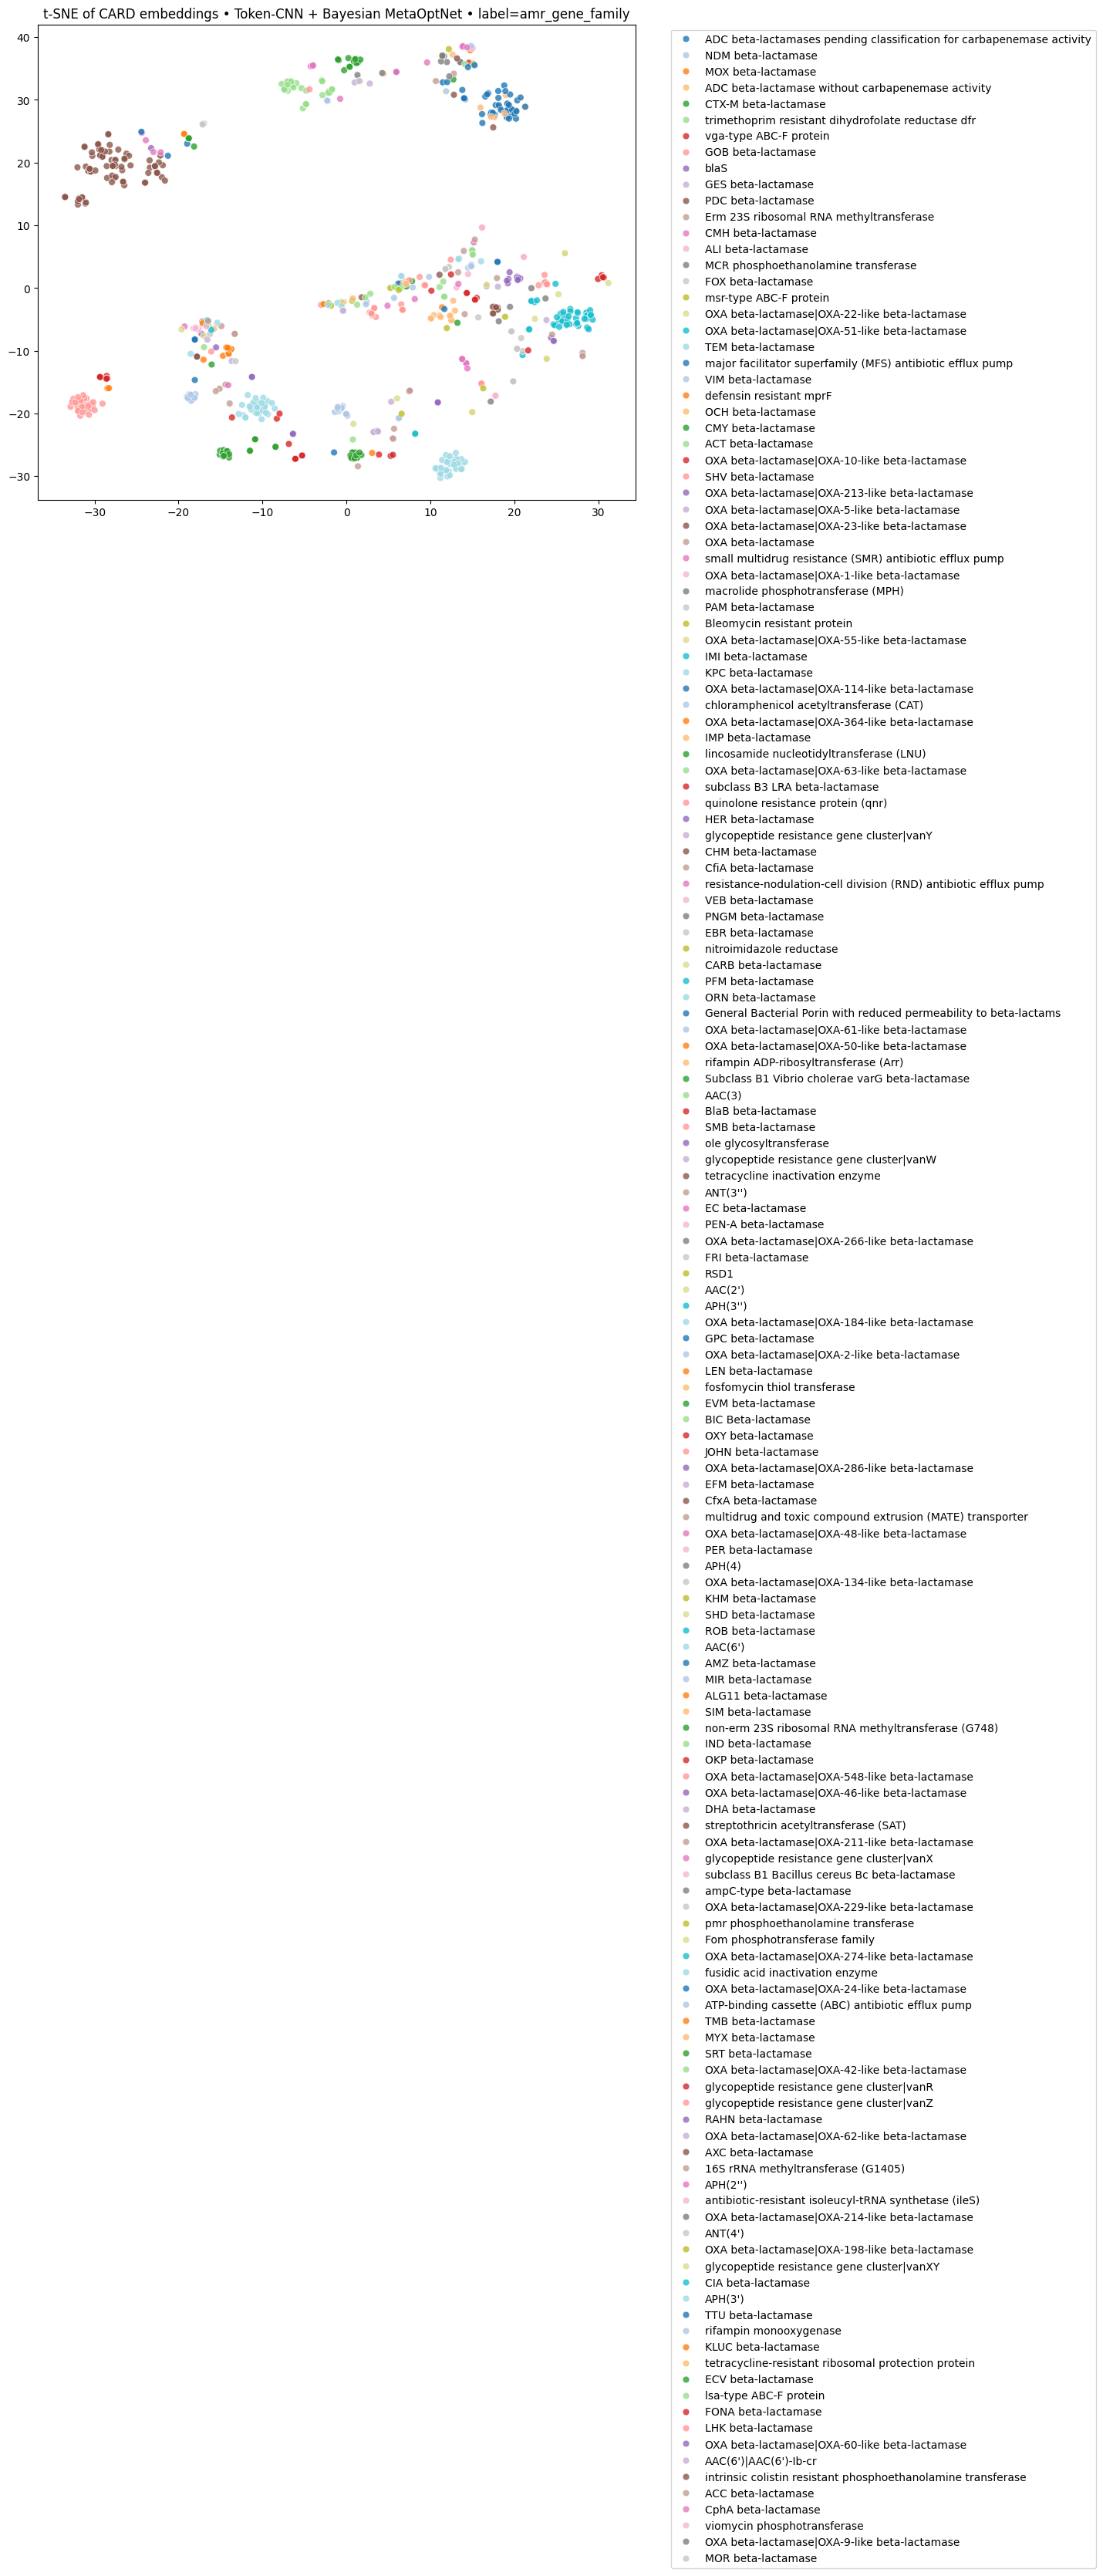

In [9]:
# =======================================
# t-SNE for Token-CNN + Bayesian MetaOptNet encoder on CARD
# =======================================
import numpy as np
import pandas as pd
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------
# CONFIG
# --------------------
LABEL_COL = "amr_gene_family"   # or "mechanism" or "drug_class"
N_MAX = 800
TSNE_PERPLEXITY = 30
RANDOM_STATE = 42

# manifest already loaded in your environment:
# manifest = pd.read_csv("seq_manifest.csv")

df_sample = manifest[manifest[LABEL_COL].notna()].copy()

def collect_embeddings_card(df_sample, encoder, n_max=N_MAX):
    """
    Sample up to n_max sequences from CARD,
    encode using MEGARes tokenizer + numeric normalization,
    return embeddings + labels.
    """
    encoder.eval()

    sample = df_sample.sample(
        min(n_max, len(df_sample)),
        random_state=RANDOM_STATE
    ).reset_index(drop=True)

    toks, nums = [], []
    for _, r in sample.iterrows():
        ids = encode_seq(r["sequence"])      # uses stoi / 5-mers
        toks.append(pad_ids(ids))           # pad to MAX_LEN
        nums.append([r["gc_content"], r["seq_len"]])

    toks = torch.tensor(np.stack(toks)).long().to(device)
    nums = torch.tensor((np.stack(nums) - num_mean)/(num_std+1e-6)).float().to(device)

    with torch.no_grad():
        feats = encoder(toks, nums).cpu().numpy()

    labels = sample[LABEL_COL].values
    return feats, labels

# ---- collect
feats, labels = collect_embeddings_card(df_sample, encoder, n_max=N_MAX)

print(f"Running t-SNE on {len(labels)} CARD samples ({LABEL_COL})...")

tsne = TSNE(
    n_components=2,
    perplexity=min(TSNE_PERPLEXITY, len(labels)//3),
    random_state=RANDOM_STATE,
    init="pca",
    learning_rate="auto"
)
reduced = tsne.fit_transform(feats)

# ---- plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=labels,
    palette="tab20",
    s=40,
    alpha=0.8,
    legend="full"
)
plt.title(f"t-SNE of CARD embeddings • Token-CNN + Bayesian MetaOptNet • label={LABEL_COL}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


[t-SNE] Using 500 CARD samples across 10 amr_gene_family classes.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



=== t-SNE Diagnostic Summary (Bayesian MetaOptNet-Ridge on CARD) ===
Number of points visualized:      500
Number of unique amr_gene_familys:    10
Embeddings dim before t-SNE:      256
Embeddings dim after  t-SNE:      2
Silhouette score:                 0.606
Mean intra-class distance:        4.309
Mean inter-class distance:        33.906
Inter / Intra ratio:              7.869
ARI (KMeans vs true):             0.828
NMI (KMeans vs true):             0.897



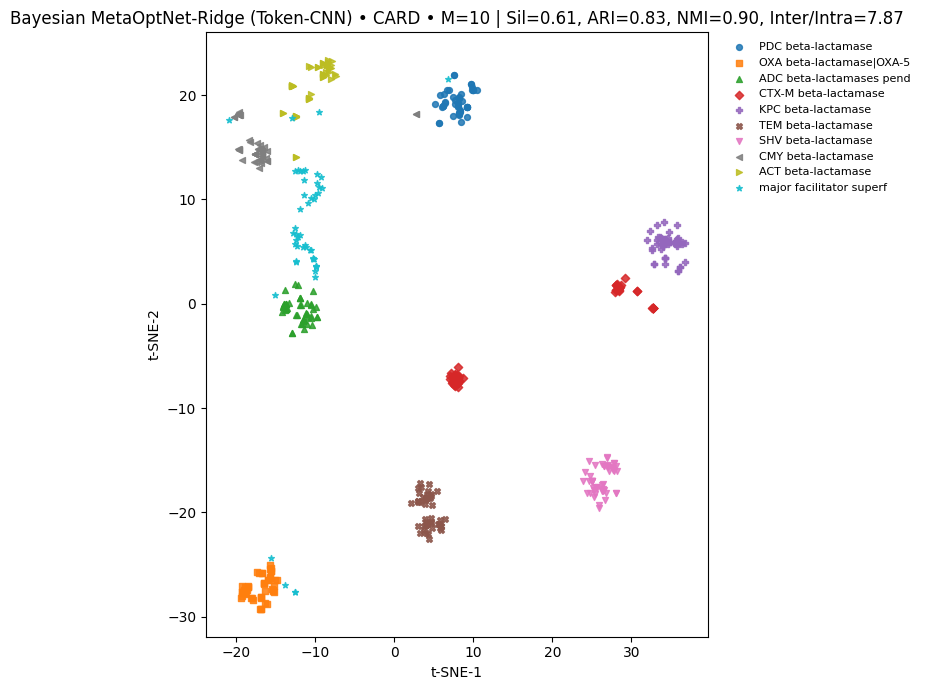

In [10]:
# ============================
# t-SNE for Token-CNN + Bayesian MetaOptNet-Ridge (with summary stats)
# on CARD (seq_manifest.csv)
# ============================
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    pairwise_distances
)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# ---- CONFIG ----
LABEL_COL      = "amr_gene_family"   # or "mechanism" or "drug_class"
TOP_M_CLASSES  = 10                  # top classes by frequency in CARD
N_PER_CLASS    = 50                  # max points per class
TSNE_PERPLEX   = 30
RANDOM_STATE   = 42

# encoder should already be loaded:
# encoder = CNNSeqEncoder(...)
# encoder.load_state_dict(...)
encoder.eval()

# manifest should come from seq_manifest.csv and already cleaned
# manifest = pd.read_csv("seq_manifest.csv", dtype=str)
# manifest["gc_content"] = manifest["gc_content"].astype(float)
# manifest["seq_len"]    = manifest["seq_len"].astype(float)

# -------- choose subset from CARD --------
base_df = manifest[
    manifest[LABEL_COL].notna()
    & (manifest[LABEL_COL] != "NA")
].copy()

counts = base_df[LABEL_COL].value_counts()
kept_labels = counts.head(TOP_M_CLASSES).index.tolist()

subset_list = []
for lab in kept_labels:
    sub = base_df[base_df[LABEL_COL] == lab]
    if len(sub) > N_PER_CLASS:
        sub = sub.sample(N_PER_CLASS, random_state=RANDOM_STATE)
    subset_list.append(sub)

subset = pd.concat(subset_list).reset_index(drop=True)
print(f"[t-SNE] Using {len(subset)} CARD samples across {len(kept_labels)} {LABEL_COL} classes.")

# -------- encode with SAME pipeline (5-mers + MEGARes norms) --------
toks = []
nums = []
for _, r in subset.iterrows():
    ids = encode_seq(r["sequence"])          # uses stoi / 5-mers
    toks.append(pad_ids(ids))                # MAX_LEN padding
    nums.append([r["gc_content"], r["seq_len"]])

tok = np.stack(toks).astype(np.int64)
num = np.stack(nums).astype(np.float32)
num = (num - num_mean) / (num_std + 1e-6)    # MEGARes train stats

y_str = subset[LABEL_COL].values

with torch.no_grad():
    Xt = torch.from_numpy(tok).long().to(device)
    Xn = torch.from_numpy(num).float().to(device)
    Z  = encoder(Xt, Xn).detach().cpu().numpy()  # [N, 256]

num_points  = len(Z)
num_classes = len(np.unique(y_str))
emb_before  = Z.shape[1]

# -------- t-SNE --------
perplexity = min(TSNE_PERPLEX, max(5, len(Z)//4 - 1))
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    metric="euclidean",
    init="pca",
    learning_rate="auto",
    n_iter=1000,
    random_state=RANDOM_STATE,
    verbose=0,
)
Z2 = tsne.fit_transform(Z)
emb_after = Z2.shape[1]

# -------- clustering diagnostics --------
label_to_int = {lab: i for i, lab in enumerate(kept_labels)}
y_int = np.array([label_to_int.get(v, -1) for v in y_str])

sil = silhouette_score(Z2, y_int, metric="euclidean") if num_classes > 1 else float("nan")

kmeans = KMeans(n_clusters=num_classes, n_init="auto", random_state=RANDOM_STATE)
pred = kmeans.fit_predict(Z2)
ari = adjusted_rand_score(y_int, pred)
nmi = normalized_mutual_info_score(y_int, pred)

D = pairwise_distances(Z2, metric="euclidean")
intra = [D[i, y_int == y_int[i]].mean() for i in range(num_points)]
inter = [D[i, y_int != y_int[i]].mean() for i in range(num_points)]
mean_intra = float(np.nanmean(intra))
mean_inter = float(np.nanmean(inter))
ratio = (mean_inter / mean_intra) if mean_intra > 0 else float("nan")

print("\n=== t-SNE Diagnostic Summary (Bayesian MetaOptNet-Ridge on CARD) ===")
print(f"Number of points visualized:      {num_points}")
print(f"Number of unique {LABEL_COL}s:    {num_classes}")
print(f"Embeddings dim before t-SNE:      {emb_before}")
print(f"Embeddings dim after  t-SNE:      {emb_after}")
print(f"Silhouette score:                 {sil:.3f}")
print(f"Mean intra-class distance:        {mean_intra:.3f}")
print(f"Mean inter-class distance:        {mean_inter:.3f}")
print(f"Inter / Intra ratio:              {ratio:.3f}")
print(f"ARI (KMeans vs true):             {ari:.3f}")
print(f"NMI (KMeans vs true):             {nmi:.3f}")
print("=================================================================\n")

# -------- plot --------
plt.figure(figsize=(8, 7))
markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*"]
for i, lab in enumerate(kept_labels):
    idx = (y_str == lab)
    plt.scatter(
        Z2[idx, 0],
        Z2[idx, 1],
        s=18,
        marker=markers[i % len(markers)],
        alpha=0.85,
        label=lab[:24],
    )

plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.title(
    f"Bayesian MetaOptNet-Ridge (Token-CNN) • CARD • M={num_classes} | "
    f"Sil={sil:.2f}, ARI={ari:.2f}, NMI={nmi:.2f}, Inter/Intra={ratio:.2f}"
)
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=8,
    ncol=1,
    frameon=False,
)
plt.tight_layout()
plt.show()


[t-SNE] pooling 3 episodes from splits_amr_gene_family/K5
[t-SNE] total points: 300, dim=256


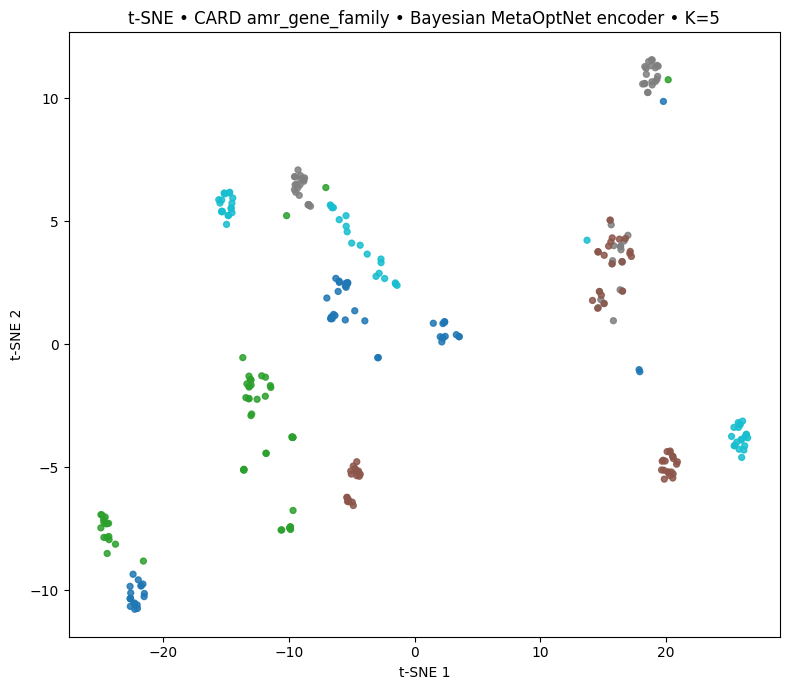

In [11]:
# ============================
# t-SNE for Token-CNN + Bayesian MetaOptNet encoder (CARD)
# ============================
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- config for visualization ---
K_PICK          = 5              # which K to visualize (must exist in splits)
EPISODES_TO_VIS = [0, 1, 2]      # episode indices to pool
TSNE_PERPLEXITY = 30
RANDOM_STATE    = 42

# ---- collect embeddings from a few episodes ----
root = Path(SPLITS_ROOT) / f"K{K_PICK}"
all_eps = sorted([p for p in root.iterdir() if p.is_dir()])
if len(all_eps) == 0:
    raise RuntimeError(f"No episodes found in {root}")

# pick the requested episodes (guard against short list)
pick_eps = [all_eps[i] for i in EPISODES_TO_VIS if i < len(all_eps)]
print(f"[t-SNE] pooling {len(pick_eps)} episodes from {root}")

Embs, Ys = [], []
encoder.eval()
with torch.no_grad():
    for ep in pick_eps:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(
            ep, label_col=LABEL_COL, device=device
        )
        # encode support + query with the Bayes MetaOptNet encoder
        s_z = encoder(s_tok, s_num).cpu().numpy()
        q_z = encoder(q_tok, q_num).cpu().numpy()

        Embs.append(np.vstack([s_z, q_z]))
        Ys.append(
            np.concatenate([
                s_y.cpu().numpy(),
                q_y.cpu().numpy()
            ])
        )

X = np.vstack(Embs)
Y = np.concatenate(Ys)
print(f"[t-SNE] total points: {len(X)}, dim={X.shape[1]}")

# ---- run t-SNE ----
perplexity = min(TSNE_PERPLEXITY, max(5, len(X) // 4 - 1))
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    random_state=RANDOM_STATE,
    init="pca",
    learning_rate="auto",
)
X2 = tsne.fit_transform(X)

# ---- plot ----
plt.figure(figsize=(8, 7))
plt.scatter(X2[:, 0], X2[:, 1], c=Y, s=18, cmap="tab10", alpha=0.85)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title(f"t-SNE • CARD {LABEL_COL} • Bayesian MetaOptNet encoder • K={K_PICK}")
plt.tight_layout()
plt.show()
